# オルツ ５分足

In [6]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import re
import yfinance as yf

pattern = re.compile(r'(.+)\.T')

symbol = '260A.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='1d', interval='5m')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2024-12-25 09:05:00+09:00,610.0,617.0,605.0,610.0,76400,0.0,0.0
2024-12-25 09:10:00+09:00,611.0,615.0,606.0,613.0,55700,0.0,0.0
2024-12-25 09:15:00+09:00,614.0,624.0,614.0,619.0,115200,0.0,0.0
2024-12-25 09:20:00+09:00,620.0,632.0,620.0,625.0,149700,0.0,0.0
2024-12-25 09:25:00+09:00,627.0,630.0,612.0,619.0,125500,0.0,0.0
2024-12-25 09:30:00+09:00,619.0,619.0,610.0,613.0,94600,0.0,0.0
2024-12-25 09:35:00+09:00,612.0,612.0,604.0,607.0,106700,0.0,0.0
2024-12-25 09:40:00+09:00,607.0,611.0,604.0,605.0,32100,0.0,0.0
2024-12-25 09:45:00+09:00,606.0,606.0,603.0,605.0,26600,0.0,0.0


## パラボリック SAR

In [7]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## ローソク足チャートとパラボリック SAR

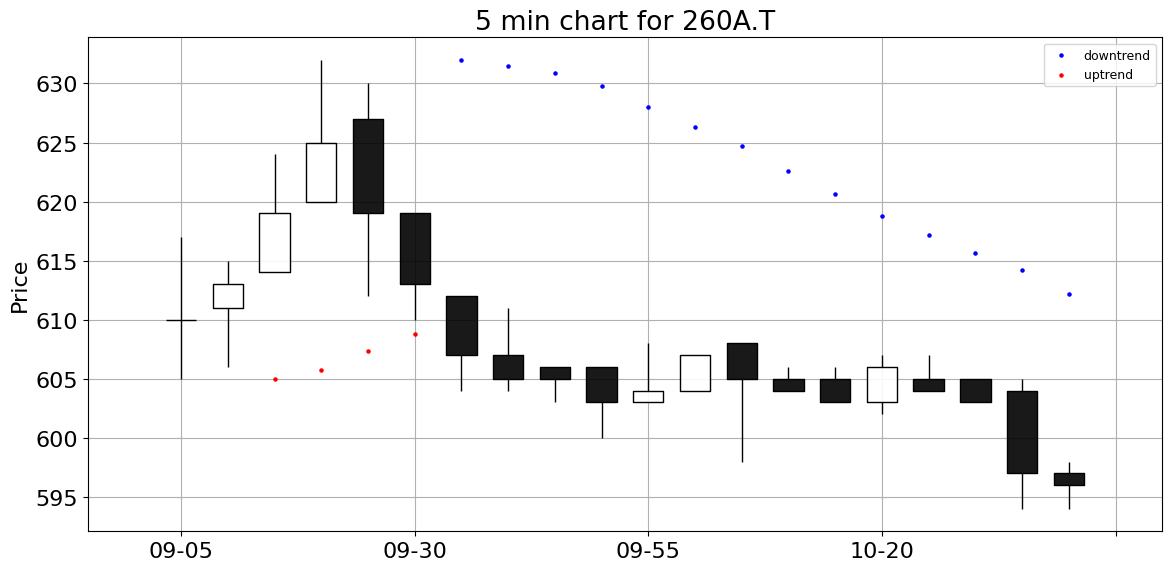

In [14]:
dict_psar = psar(df)

plt.rcParams["font.size"] = 16
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    volume=False,
    datetime_format='%H-%M',
    addplot=apds,
    xrotation=0,
    ax=ax,
)

try:
    ax.set_title('5 min chart for %s (%s)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('5 min chart for %s' % symbol)

ax.grid()
ax.legend(loc='best', fontsize=9)

plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('5min_chart_%s.png' % m.group(1))
else:
    plt.savefig('5min_chart_%s.png' % symbol)

plt.show()

In [9]:
df.tail(2)['Close']

Datetime
2024-12-25 10:35:00+09:00    597.0
2024-12-25 10:40:00+09:00    596.0
Name: Close, dtype: float64

In [10]:
df.tail(2)['Close'].diff()

Datetime
2024-12-25 10:35:00+09:00    NaN
2024-12-25 10:40:00+09:00   -1.0
Name: Close, dtype: float64